In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy
from lr_utils import load_dataset
from PIL import Image
from scipy import ndimage

%matplotlib inline

## Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("data.h5") containing:

    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    
    - a test set of m_test images labeled as cat or non-cat
    
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).
    

Builded a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

In [2]:
# Loading the data (cat/non-cat):
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. We can visualize an example 

y = [1], it's a 'cat' picture.


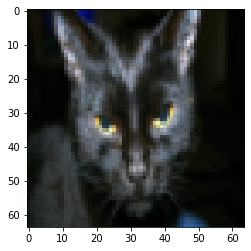

In [3]:
# Example of a picture:
index = 25
plt.imshow(train_set_x_orig[index])
print(
    "y = " +
    str(train_set_y[:, index]) +
    ", it's a '" +
    classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +
    "' picture."
)

# Baseline(random rule)
For understanding if our LogReg model better than random prediction we defined func that randomly predicts classes

In [4]:
from random import seed
from random import randrange
import numpy as np

def random_algorithm(y_train, y_test):
    seed(1)
    #unique = list(np.unique(train_set_y))
    unique = list(set(train_set_y.flat))

    predicted = list()
    for row in test_set_y[0,]:
        index = randrange(len(unique))
        predicted.append(unique[index])

    return np.array(predicted)

In [5]:
y_test_random = random_algorithm(train_set_y, test_set_y)

In [6]:
from sklearn.metrics import accuracy_score
print('Random prediction accuracy', accuracy_score(test_set_y[0,], y_test_random))

Random prediction accuracy 0.46


Now we can compare our future accuracy to baseline

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight we will go a long way toward eliminating many bugs. 

In [7]:
# START CODE HERE
m_train = train_set_x_orig.shape[0] # train_set_y.shape[1]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1] # train_set_x_orig.shape[2]
# # END CODE HERE

print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/width of each image: num_px = " + str(num_px))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape: " + str(test_set_x_orig.shape))
print("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [8]:
# Reshape the training and test examples:

# START CODE HERE
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
# # END CODE HERE

print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print("test_set_y shape: " + str(test_set_y.shape))
print("Sanity check after reshaping: " + str(train_set_x_flatten[:5, 0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
Sanity check after reshaping: [17 31 56 22 33]


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [9]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

## General Architecture of the learning algorithm ##
Builded a Logistic Regression, using a Neural Network mindset. 

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

##  Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 1. Helper functions

In [10]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z.

    Arguments:
    z: A scalar or numpy array of any size.

    Return:
    s: sigmoid(z)
    """

    s = 1/(1+np.exp(-z))


    return s


In [11]:
print("sigmoid([0, 2]) = " + str(sigmoid(np.array([0, 2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Expected Output**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 2 - Initializing parameters

In [12]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    Creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim: Size of the w vector.

    Returns:
    w: Initialized vector of shape (dim, 1).
    b: Initialized bias.
    """
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b



In [13]:
dim = 2
w, b = initialize_with_zeros(dim)
print("w = " + str(w))
print("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).

### 3 - Forward and Backward propagation

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [14]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Compute the cost function and its gradient.

    Arguments:
    w: Weights, a numpy array of size (num_px * num_px * 3, 1).
    b: Bias, a scalar.
    X: Data of size (num_px * num_px * 3, number of examples).
    Y: Label vector (containing 0 if non-cat, 1 if cat) of size (1, number of
       examples).

    Returns:
    cost: Negative log-likelihood cost for logistic regression.
    dw: Gradient of the loss with respect to w (same shape as w).
    db: Gradient of the loss with respect to b (same shape as b).
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)

    # Compute activation:
    A = sigmoid(np.dot(w.T,X)+b)

    # Compute cost:
    cost = -np.mean(Y*np.log(A)+(1-Y)*np.log(1-A))
    
    # BACKWARD PROPAGATION (FINDING THE GRADIENT)

    # diff = np.dot(w.T,X)+b*(1.0 - np.dot(w.T,X)+b)
    dw = np.dot(X, (A-Y).T)/m
    db = np.mean(A-Y)



    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw": dw, "db": db}

    return grads, cost

In [15]:
w = np.array([[1], [2]], dtype=np.float_)
b = 2.0
X = np.array([[1, 2, -1], [3, 4, -3.2]], dtype=np.float_)
Y = np.array([[1, 0, 1]], dtype=np.float_)


grads, cost = propagate(w, b, X, Y)
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))
print("cost = " + str(cost))



dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4 - Optimization
- initialized your parameters.
- able to compute a cost function and its gradient.
- update the parameters using gradient descent.


In [16]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    Optimize w and b by running gradient descent algorithm.

    Arguments:
    w: Weights, a numpy array of size (num_px * num_px * 3, 1).
    b: Bias, a scalar.
    X: Data of size (num_px * num_px * 3, number of examples).
    Y: Label vector (containing 0 if non-cat, 1 if cat) of size (1, number of
       examples).
    num_iterations: Number of iterations.
    learning_rate: Learning rate.
    print_cost: True to print the cost every 100 steps.

    Returns:
    params: Dictionary containing the weights w and bias b.
    grads: Dictionary containing the gradient of the cost function.
    costs: List of costs computed during the optimization.
    """

    costs = []

    for i in range(num_iterations):

        # Cost and gradient calculation:
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads:
        dw = grads["dw"]
        db = grads["db"]

        # Update rule:
        w -= learning_rate * dw
        b -= learning_rate * db

        # Record the costs:
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 iterations:
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}
    return params, grads, costs

In [17]:
params, grads, costs = optimize(
    w,
    b,
    X,
    Y,
    num_iterations=100,
    learning_rate=0.009,
    print_cost=False
)
print("w = " + str(params["w"]))
print("b = " + str(params["b"]))
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067654


Implemented the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [18]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression
    parameters (w, b).

    Arguments:
    w: Weights, a numpy array of size (num_px * num_px * 3, 1).
    b: Bias, a scalar.
    X: Data of size (num_px * num_px * 3, number of examples).

    Returns:
    Y_prediction: numpy array containing all predictions.
    """

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute the vector of probabilities:
    A = sigmoid(np.dot(w.T, X) + b)

    # Convert probabilities to predictions:
    Y_prediction = (A > 0.5).astype(np.float_)

    assert(Y_prediction.shape == (1, m))

    return Y_prediction

In [19]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1, -1.1, -3.2], [1.2, 2, 0.1]])
print("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


## 5 - Merge all functions into a model ##

In [20]:
# GRADED FUNCTION: model

def model(
    X_train,
    Y_train,
    X_test,
    Y_test,
    num_iterations=2000,
    learning_rate=0.5,
    print_cost=False
):
    """
    Build the logistic regression model.

    Arguments:
    X_train: Training set.
    Y_train: Training labels.
    X_test: Test set.
    Y_test: Test labels.
    num_iterations: Number of iterations.
    learning_rate: Learning rate.
    print_cost: True to print the cost every 100 steps.

    Returns:
    d: Dictionary containing information about the model.
    """

    # Initialize parameters:
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent:
    parameters, grads, costs = optimize(
        w,
        b,
        X_train,
        Y_train,
        num_iterations,
        learning_rate,
        print_cost=print_cost
    )

    # Retrieve w and b from parameters:
    w = parameters["w"]
    b = parameters["b"]

    # Compute the predictions for the training and test sets:
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)

    # Print the training and test accuracies:
    acc_train = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    print("train accuracy: {} %".format(acc_train))
    acc_test = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
    print("test accuracy: {} %".format(acc_test))

    d = {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations
    }
    return d

Run the following cell to train model.

In [21]:
d = model(
    train_set_x,
    train_set_y,
    test_set_x,
    test_set_y,
    num_iterations=2000,
    learning_rate=0.005,
    print_cost=True
)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Expected Output**: 

<table style="width:40%"> 

    <tr>
        <td> **Cost after iteration 0 **  </td> 
        <td> 0.693147 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 99.04306220095694 % </td>
    </tr>

    <tr>
        <td>**Test Accuracy** </td> 
        <td> 70.0 % </td>
    </tr>
</table> 




**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test accuracy is 70%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. 

Also, the model is clearly overfitting the training data.

y = 1, you predicted that it is a "cat" picture.


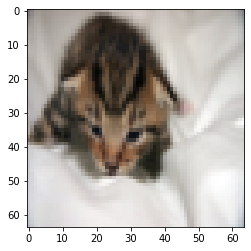

In [22]:
index = int(1)
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

Let's also plot the cost function and the gradients.

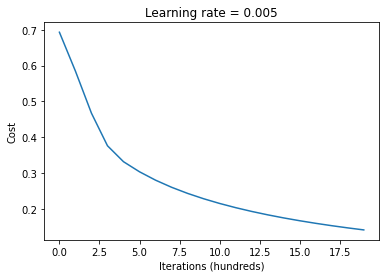

In [23]:
# Plot learning curve:
costs = np.squeeze(d["costs"])
plt.plot(costs)
plt.xlabel("Iterations (hundreds)")
plt.ylabel("Cost")
plt.title("Learning rate = " + str(d["learning_rate"]))
plt.show()

**Interpretation**:
The cost decreasing. It shows that the parameters are being learned. However, we could train the model even more on the training set. We can try to increase the number of iterations in the cell above and rerun the cells. Than we might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

## 6 - Further analysis (optional/ungraded exercise) ##

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

#### Choice of learning rate ####

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "overshoot" the optimal value. Similarly, if it is too small we will need too many iterations to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.005
train accuracy: 97.60765550239235 %
test accuracy: 70.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



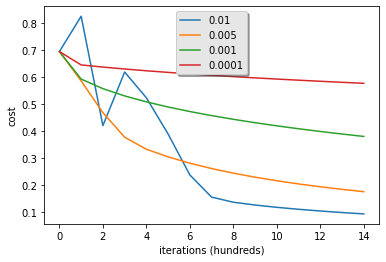

In [24]:
learning_rates = [0.01, 0.005, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. 


# In this case is better to use lr = 0.005 because test accuracy is higher. For better estimation cross-validation can be used. And for better learning rate choosing can be used GrigSearchCV